#**Training and Running Sentiment Analysis (Naive Bayes Classifier) Model to research public sentiments on LLM**

In this, we will walk through a data science project focused on cleaning and classifying reddit comments to get real public sentiments on the advance of LLM applications.

We'll use Python libraries such as ***pandas***, ***NLTK***, ***scikit-learn***, and ***imbalanced-learn*** to accomplish this.

Below is the breakdown of the code and what it does at each step.

##**Importing Necessary Libraries**

We start by importing the essential libraries for data manipulation, visualization, and sentiment analysis.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE


##**Loading and Inspecting the Dataset**

Next, we load our dataset, which contains pre-labeled tweets and their associated sentiments (Positive, Negative or Neutral) to required to train the NLP model.

In [6]:
df = pd.read_csv("Tweets and sentiment.csv")
df = df.drop('sno', axis =1)
df.columns

Index(['tweet', 'sentiment'], dtype='object')

##**Downloading NLTK Data**
Before processing text data, we need to download some necessary data from the NLTK library. This includes tokenizers, stop words, and the WordNet lemmatizer.

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##**Cleaning the Tweets**

We define a function to clean the tweets by removing Twitter handles, URLs, special characters, stop words, and by performing tokenization and lemmatization.

This step ensures that our text data is in a suitable format for further analysis.

In [8]:
def clean_tweet(tweet):
    # Remove Twitter handles
    tweet = re.sub(r'@[\w]+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)

    # Remove special characters and punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Tokenization
    tokens = word_tokenize(tweet)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lowercasing
    tokens = [word.lower() for word in tokens]

    # Remove numbers
    tokens = [word for word in tokens if not word.isdigit()]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    cleaned_tweet = ' '.join(tokens)

    return cleaned_tweet

df['tweet'] = df['tweet'].apply(clean_tweet)
print(df.head())


                                               tweet sentiment
0         chatgpt optimizing language model dialogue   neutral
1  try talking chatgpt new ai system optimized di...      good
2  chatgpt optimizing language model dialogue ai ...   neutral
3  thrilled share chatgpt new model optimized dia...      good
4    minute ago released new chatgpt nnand use right       bad


##**Converting Text into Numerical Data**

We use the ***CountVectorizer*** to transform the text data into numerical data suitable for machine learning algorithms. This step converts the cleaned text into a matrix of token counts.

In [9]:
vectorizer = CountVectorizer()
train_vectors = vectorizer.fit_transform(df['tweet'])


##**Balancing the Classes with SMOTE**

To handle any class imbalances in our dataset, we use the ***SMOTE (Synthetic Minority Over-sampling Technique)*** method.

SMOTE generates synthetic samples for the minority class to ensure the model does not become biased towards the majority class.

In [10]:
smote = SMOTE(sampling_strategy='auto', random_state=1111)
train_vectors_resampled, train_labels_resampled = smote.fit_resample(train_vectors, df['sentiment'])


##**Training the Sentiment Analysis Model**
We use the Multinomial Naive Bayes algorithm to train our sentiment analysis model. This algorithm is well-suited for text classification tasks, which is the same in our case of comments and tweets.

In [11]:
model = MultinomialNB()
model.fit(train_vectors_resampled, train_labels_resampled)


MultinomialNB()

##**Evaluating the Model**
Since the model has been trained and tested. We evaluate the performance of our model using accuracy score, confusion matrix, and classification report. These metrics help us understand how well our model is performing.

Accuracy: 0.80
Confusion Matrix:
[[88904  7334 11558]
 [ 1332 49300  5379]
 [ 5467 13248 36772]]


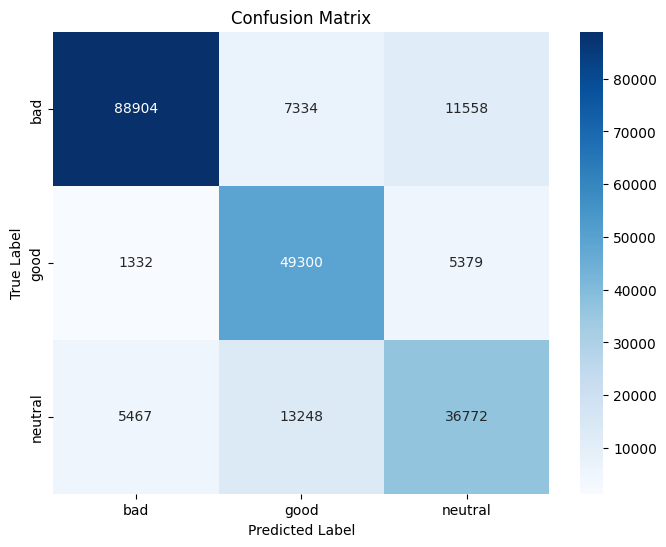


Classification Report:
              precision    recall  f1-score   support

         bad       0.93      0.82      0.87    107796
        good       0.71      0.88      0.78     56011
     neutral       0.68      0.66      0.67     55487

    accuracy                           0.80    219294
   macro avg       0.77      0.79      0.78    219294
weighted avg       0.81      0.80      0.80    219294



In [12]:
  # Evaluations
predictions = model.predict(train_vectors)
accuracy = accuracy_score(df['sentiment'], predictions)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(df['sentiment'], predictions)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(df['sentiment'], predictions))


##**Applying the Model to the Reddit Dataset**
Since the model is working fine with good recall and precision for key categories, i.e. Good and Bad, we can now go ahead an run it on the scraped Reddit Data.

We apply our trained model to the Reddit dataset containing comments to predict their sentiments. This step involves preprocessing the new comments, predicting their sentiment using our trained model, and saving the results to a new file.

In [14]:
# Redddit Scraped dataset
dfnew = pd.read_excel('scraped data.xlsx')

# Preprocess the comments in the reddit dataset
dfnew['comment'] = dfnew['comment'].apply(clean_tweet)

dfnew['predicted_sentiment'] = model.predict(vectorizer.transform(dfnew['comment']))

#saving the comments in the new file
dfnew.to_excel('output_comments_with_sentiment.xlsx', index=False)
